# Seq2Seq: _Multivariate, Multi-step_ architectures - LSTM & GRU with TF2.8

#### Metro Interstate Traffic Volume Data Set

__Abstract:__ Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.

__Data Set Information:__
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


Attribute Information:

1. holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
2. temp Numeric Average temp in kelvin
3. rain_1h Numeric Amount in mm of rain that occurred in the hour
4. snow_1h Numeric Amount in mm of snow that occurred in the hour
5. clouds_all Numeric Percentage of cloud cover
6. weather_main Categorical Short textual description of the current weather
7. weather_description Categorical Longer textual description of the current weather
8. date_time DateTime Hour of the data collected in local CST time
9. traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume


__Predict all numeric features (multivariate sequence predictions)__.


Refer-
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume


In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


In [4]:
# Read processed data-
data = pd.read_csv("Metro_Interstate_Traffic_Volume_processed.csv", low_memory = False)

In [5]:
data.shape

(48204, 6)

In [6]:
# Get data types-
data.dtypes

temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
traffic_volume      int64
date_time          object
dtype: object

In [7]:
# Convert 'date_time' attribute to datetime, sort & reset indices-
data['date_time'] = pd.to_datetime(data['date_time'])
data.sort_values(by = 'date_time', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [8]:
# Sanity check-
data.dtypes

temp                     float64
rain_1h                  float64
snow_1h                  float64
clouds_all                 int64
traffic_volume             int64
date_time         datetime64[ns]
dtype: object

In [9]:
# Sanity check-
data.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,date_time
0,288.28,0.0,0.0,40,5545,2012-10-02 09:00:00
1,289.36,0.0,0.0,75,4516,2012-10-02 10:00:00
2,289.58,0.0,0.0,90,4767,2012-10-02 11:00:00
3,290.13,0.0,0.0,90,5026,2012-10-02 12:00:00
4,291.14,0.0,0.0,75,4918,2012-10-02 13:00:00


In [10]:
print(f"min date time: {data['date_time'].min()} & max: {data['date_time'].max()}")

min date time: 2012-10-02 09:00:00 & max: 2018-09-30 23:00:00


In [11]:
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins (rule of thumb) = {num_bins}")

number of bins (rule of thumb) = 220


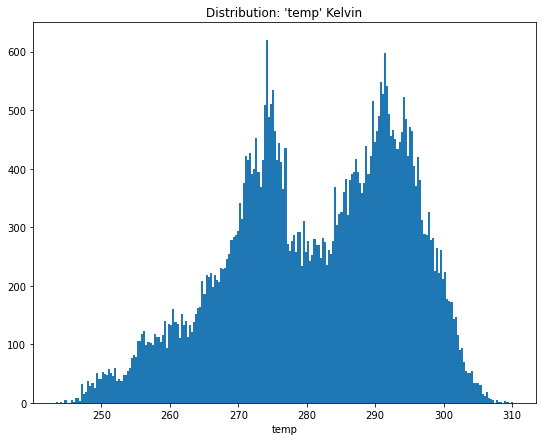

In [12]:
plt.figure(figsize = (9, 7))
plt.hist(data['temp'], bins = num_bins)
plt.xlabel("temp")
plt.title("Distribution: 'temp' Kelvin")
plt.show()

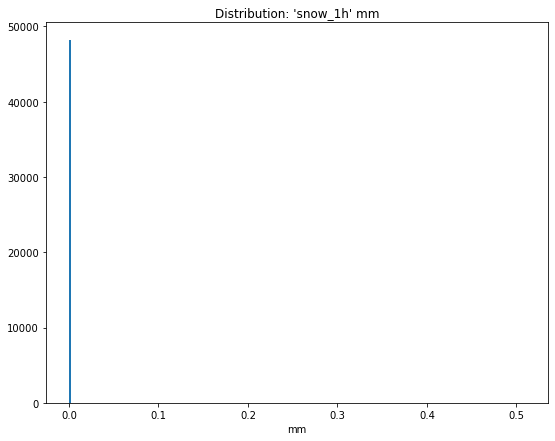

In [18]:
plt.figure(figsize = (9, 7))
plt.hist(data['snow_1h'], bins = num_bins)
plt.xlabel("mm")
plt.title("Distribution: 'snow_1h' mm")
plt.show()

In [16]:
# Majority of values for 'snow_1h' are 0s-
len(data.loc[data['snow_1h'] == 0, 'snow_1h']), len(data)

(48141, 48204)

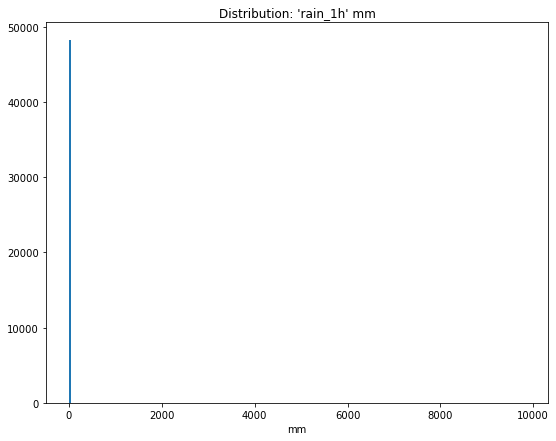

In [17]:
plt.figure(figsize = (9, 7))
plt.hist(data['rain_1h'], bins = num_bins)
plt.xlabel("mm")
plt.title("Distribution: 'rain_1h' mm")
plt.show()

In [19]:
# Majority of values for 'rain_1h' are 0s-
len(data.loc[data['rain_1h'] == 0, 'rain_1h']), len(data)

(44737, 48204)

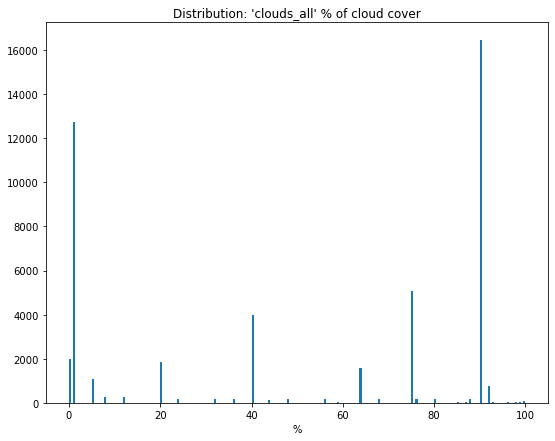

In [20]:
plt.figure(figsize = (9, 7))
plt.hist(data['clouds_all'], bins = num_bins)
plt.xlabel("%")
plt.title("Distribution: 'clouds_all' % of cloud cover")
plt.show()

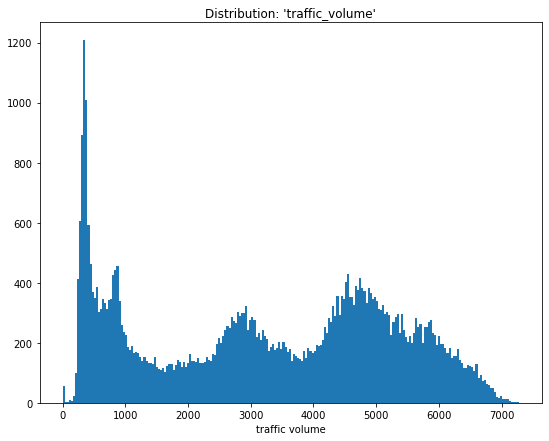

In [21]:
plt.figure(figsize = (9, 7))
plt.hist(data['traffic_volume'], bins = num_bins)
plt.xlabel("traffic volume")
plt.title("Distribution: 'traffic_volume'")
plt.show()

In [24]:
print(f"# of 0s for 'traffic_volume': {len(data.loc[data['traffic_volume'] == 0, 'traffic_volume'])}")

# of 0s for 'traffic_volume': 2


In [ ]:
# data.loc[data['traffic_volume'] == 0, 'traffic_volume'] = 0.01

In [ ]:
'''
plt.figure(figsize = (9, 7))
plt.hist(np.log(data['traffic_volume']), bins = num_bins)
plt.xlabel("traffic volume")
plt.title("Distribution: log-transform 'traffic_volume'")
plt.show()
'''

In [25]:
# Use standard scaler-
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(data.iloc[:, :-1])

In [26]:
# Sanity check-
data.shape, data_scaled.shape

((48204, 6), (48204, 5))

In [27]:
data_scaled[:5, :]

array([[ 0.55205015, -0.00746314, -0.02722834, -0.23996279,  1.15015883],
       [ 0.63703499, -0.00746314, -0.02722834,  0.65712012,  0.63225101],
       [ 0.65434672, -0.00746314, -0.02722834,  1.04158422,  0.75858227],
       [ 0.69762604, -0.00746314, -0.02722834,  1.04158422,  0.88894002],
       [ 0.77710261, -0.00746314, -0.02722834,  0.65712012,  0.83458235]])

In [28]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_scaled[: int(len(data_scaled) * 0.9)]), len(data_scaled[int(len(data_scaled) * 0.9): ])

(43383, 4821)

In [29]:
# Sanity check-
len(data_scaled[: int(len(data_scaled) * 0.9)]) + len(data_scaled[int(len(data_scaled) * 0.9): ]) == len(data_scaled)

True

In [30]:
train_data = data_scaled[: int(len(data_scaled) * 0.9), :]
test_data = data_scaled[int(len(data_scaled) * 0.9):, :]

In [31]:
# Sanity check-
train_data.shape, test_data.shape

((43383, 5), (4821, 5))

In [32]:
# Further sanity check-
train_data[-5:, :]

array([[-0.79669083, -0.00746314, -0.02722834, -1.13704571,  1.21659599],
       [-0.63852459, -0.00746314, -0.02722834, -1.13704571,  0.60205231],
       [-0.57163837, -0.00746314, -0.02722834, -1.23956947,  0.73241006],
       [-0.48744042, -0.00746314, -0.02722834, -1.23956947,  0.85672807],
       [-0.41504592, -0.00746314, -0.02722834, -1.13704571,  0.83206579]])

In [33]:
test_data[:5, :]

array([[-0.36625833, -0.00746314, -0.02722834, -1.23956947,  0.9865825 ],
       [-0.28992934, -0.00746314, -0.02722834, -1.23956947,  1.30064905],
       [-0.23327278, -0.00746314, -0.02722834, -1.13704571,  1.70984153],
       [-0.19078036, -0.00746314, -0.02722834, -1.13704571,  1.51858305],
       [-0.16009139, -0.00746314, -0.02722834, -0.23996279,  0.78878098]])

In [34]:
data_scaled[43378:43388, :]

array([[-0.79669083, -0.00746314, -0.02722834, -1.13704571,  1.21659599],
       [-0.63852459, -0.00746314, -0.02722834, -1.13704571,  0.60205231],
       [-0.57163837, -0.00746314, -0.02722834, -1.23956947,  0.73241006],
       [-0.48744042, -0.00746314, -0.02722834, -1.23956947,  0.85672807],
       [-0.41504592, -0.00746314, -0.02722834, -1.13704571,  0.83206579],
       [-0.36625833, -0.00746314, -0.02722834, -1.23956947,  0.9865825 ],
       [-0.28992934, -0.00746314, -0.02722834, -1.23956947,  1.30064905],
       [-0.23327278, -0.00746314, -0.02722834, -1.13704571,  1.70984153],
       [-0.19078036, -0.00746314, -0.02722834, -1.13704571,  1.51858305],
       [-0.16009139, -0.00746314, -0.02722834, -0.23996279,  0.78878098]])

In [35]:
def split_series(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s).
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        # past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [36]:
# Define hyper-parameters-
n_past = 14
n_future = 5 
n_features = 5

In [37]:
X_train, y_train = split_series(train_data, n_past, n_future)
X_test, y_test = split_series(test_data, n_past, n_future)

In [38]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (43365, 14, 5), y_train.shape: (43365, 5, 5)
X_test.shape: (4803, 14, 5), y_test.shape: (4803, 5, 5)


In [39]:
 X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)).shape, y_train.reshape((y_train.shape[0], y_train.shape[1], n_features)).shape

((43365, 14, 5), (43365, 5, 5))

In [40]:
X_test.reshape((X_test.shape[0], X_test.shape[1], n_features)).shape, y_test.reshape((y_test.shape[0], y_test.shape[1], n_features)).shape

((4803, 14, 5), (4803, 5, 5))

### Define _Seq2Seq_ architecture for multivariate, multistep & multivariate output architectures:

#### Sequence to Sequence Model with one encoder layer and one decoder layer-

In [41]:
# Encoder-
encoder_inputs = Input(shape = (n_past, n_features))
encoder_l1 = LSTM(
    units = 100, return_state = True,
    activation = tf.keras.activations.tanh
)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

In [42]:
# Decoder-
decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = LSTM(
    units = 100, return_sequences = True,
    activation = tf.keras.activations.tanh
)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(
    Dense(units = n_features)
)(decoder_l1)

#### Sequence to Sequence Model with two encoder layers and two decoder layers-

In [70]:
# Encoder-
encoder_inputs = Input(shape = (n_past, n_features))
encoder_l1 = LSTM(
    units = 100, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(
    100, return_state = True,
    activation = tf.keras.activations.tanh
)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

In [71]:
# Decoder-
decoder_inputs = RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = LSTM(
    units = 100, return_sequences = True,
    activation = tf.keras.activations.tanh
)(decoder_inputs, initial_state = encoder_states1)
decoder_l2 = LSTM(
    units = 100, return_sequences = True,
    activation = tf.keras.activations.tanh
)(decoder_l1, initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(
    Dense(units = n_features))(decoder_l2)

In [45]:
# Define model-
model_e1d1 = Model(encoder_inputs, decoder_outputs1)

In [72]:
# Define model-
model_e2d2 = Model(encoder_inputs, decoder_outputs2)

In [46]:
# Get model summary-
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        42400       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [73]:
# Get model summary-
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 14, 5)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 14, 100),    42400       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

In [47]:
# Define LR scheduler-
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [53]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 5, verbose = 1,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)


In [48]:
# Compile model-
model_e1d1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
)

In [74]:
model_e2d2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
)

In [49]:
# Sanity check-
X_train[:2, :].shape, y_train[:2].shape

((2, 14, 5), (2, 5, 5))

In [50]:
y_pred = model_e1d1(X_train[:2, :])

In [52]:
y_pred.shape, y_train[:2].shape

(TensorShape([2, 5, 5]), (2, 5, 5))

In [75]:
y_pred_e2d2 = model_e2d2(X_train[:2])

In [76]:
y_pred_e2d2.shape, y_test[:2].shape

(TensorShape([2, 5, 5]), (2, 5, 5))

In [77]:
del y_pred, y_pred_e2d2

In [54]:
# Train model-
history_e1d1 = model_e1d1.fit(
    x = X_train, y = y_train,
    epochs = 25, batch_size = 128,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, early_stopping_criterion]
)

Epoch 1/25
339/339 [==============================] - 8s 18ms/step - loss: 0.0963 - val_loss: 0.0780 - lr: 0.0010
Epoch 2/25
339/339 [==============================] - 6s 18ms/step - loss: 0.0759 - val_loss: 0.0731 - lr: 9.0000e-04
Epoch 3/25
339/339 [==============================] - 6s 17ms/step - loss: 0.0720 - val_loss: 0.0710 - lr: 8.1000e-04
Epoch 4/25
339/339 [==============================] - 6s 18ms/step - loss: 0.0701 - val_loss: 0.0705 - lr: 7.2900e-04
Epoch 5/25
339/339 [==============================] - 6s 17ms/step - loss: 0.0688 - val_loss: 0.0678 - lr: 6.5610e-04
Epoch 6/25
339/339 [==============================] - 6s 16ms/step - loss: 0.0677 - val_loss: 0.0661 - lr: 5.9049e-04
Epoch 7/25
339/339 [==============================] - 5s 16ms/step - loss: 0.0669 - val_loss: 0.0666 - lr: 5.3144e-04
Epoch 8/25
339/339 [==============================] - 6s 18ms/step - loss: 0.0662 - val_loss: 0.0646 - lr: 4.7830e-04
Epoch 9/25
339/339 [==============================] - 6s 19m

In [78]:
# Train model-
history_e2d2 = model_e2d2.fit(
    x = X_train, y = y_train,
    epochs = 25, batch_size = 128,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, early_stopping_criterion]
)

Epoch 1/25
339/339 [==============================] - 15s 36ms/step - loss: 0.0978 - val_loss: 0.0767 - lr: 0.0010
Epoch 2/25
339/339 [==============================] - 12s 35ms/step - loss: 0.0758 - val_loss: 0.0706 - lr: 9.0000e-04
Epoch 3/25
339/339 [==============================] - 12s 34ms/step - loss: 0.0715 - val_loss: 0.0694 - lr: 8.1000e-04
Epoch 4/25
339/339 [==============================] - 13s 37ms/step - loss: 0.0694 - val_loss: 0.0656 - lr: 7.2900e-04
Epoch 5/25
339/339 [==============================] - 14s 41ms/step - loss: 0.0679 - val_loss: 0.0658 - lr: 6.5610e-04
Epoch 6/25
339/339 [==============================] - 15s 44ms/step - loss: 0.0668 - val_loss: 0.0666 - lr: 5.9049e-04
Epoch 7/25
339/339 [==============================] - 16s 47ms/step - loss: 0.0661 - val_loss: 0.0646 - lr: 5.3144e-04
Epoch 8/25
339/339 [==============================] - 19s 57ms/step - loss: 0.0653 - val_loss: 0.0644 - lr: 4.7830e-04
Epoch 9/25
339/339 [==============================] 

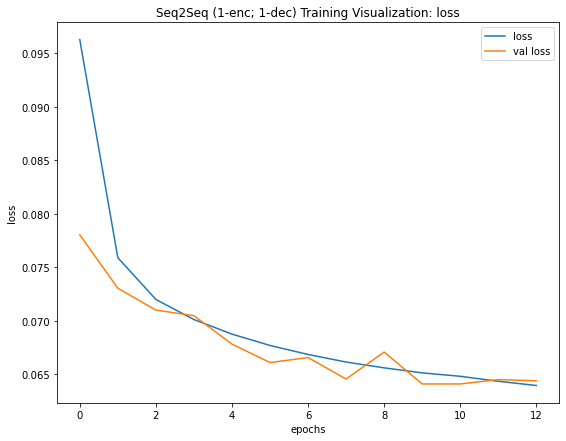

In [79]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(history_e1d1.history['loss'], label = 'loss')
plt.plot(history_e1d1.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Seq2Seq (1-enc; 1-dec) Training Visualization: loss")
plt.legend(loc = 'best')
plt.show()

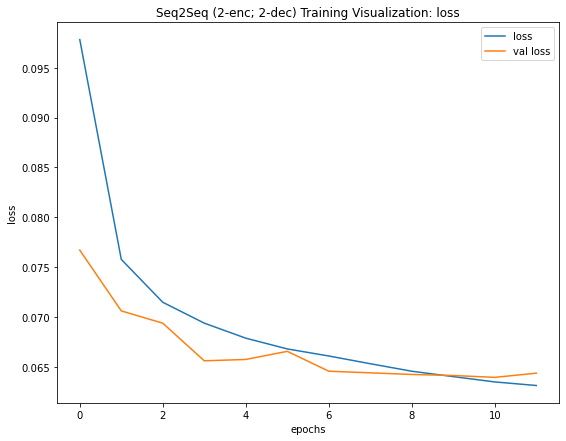

In [82]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(history_e2d2.history['loss'], label = 'loss')
plt.plot(history_e2d2.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Seq2Seq (2-enc; 2-dec) Training Visualization: loss")
plt.legend(loc = 'best')
plt.show()

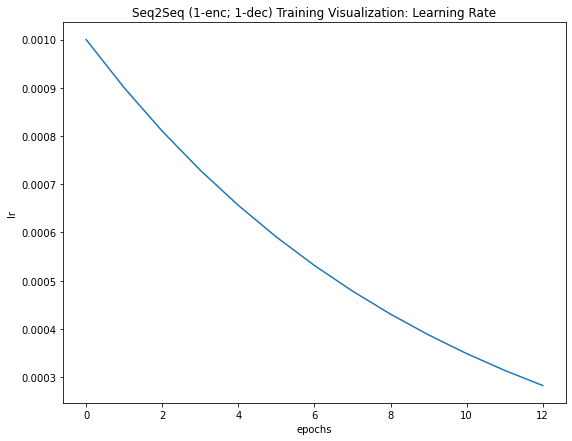

In [81]:
plt.figure(figsize = (9, 7))
plt.plot(history_e1d1.history['lr'])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("Seq2Seq (1-enc; 1-dec) Training Visualization: Learning Rate")
plt.show()

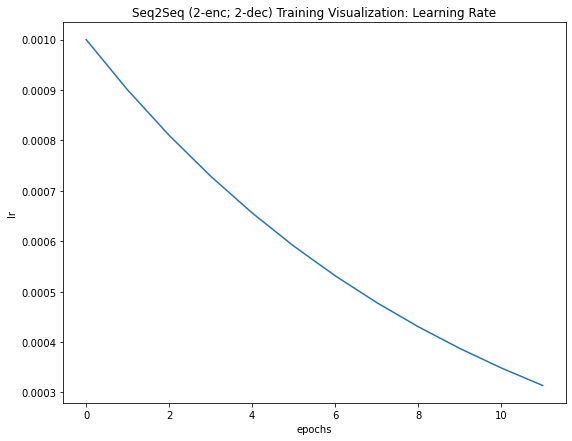

In [83]:
plt.figure(figsize = (9, 7))
plt.plot(history_e2d2.history['lr'])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("Seq2Seq (2-enc; 2-dec) Training Visualization: Learning Rate")
plt.show()

In [85]:
# Make predictions using trained model-
y_pred_e1_d1 = model_e1d1(X_test).numpy()
y_pred_e2_d2 = model_e2d2(X_test).numpy()

In [86]:
# Sanity check-
y_pred_e1_d1.shape, y_pred_e2_d2.shape, y_test.shape

((4803, 5, 5), (4803, 5, 5), (4803, 5, 5))

In [87]:
# Compute different metrics-
mse_e1_d1 = np.mean(np.square(y_pred_e1_d1.flatten() - y_test.flatten()))
rmse_e1_d1 = np.sqrt(mse_e1_d1)
mae_e1_d1 = np.mean(np.abs(y_pred_e1_d1.flatten() - y_test.flatten()))

In [88]:
# Compute different metrics-
mse_e2_d2 = np.mean(np.square(y_pred_e2_d2.flatten() - y_test.flatten()))
rmse_e2_d2 = np.sqrt(mse_e2_d2)
mae_e2_d2 = np.mean(np.abs(y_pred_e2_d2.flatten() - y_test.flatten()))

In [90]:
print("Trained model validation metrics:")
print(f"E1-D1; MSE: {mse_e1_d1:.4f}, RMSE: {rmse_e1_d1:.4f} & MAE: {mae_e1_d1:.4f}")
print(f"E1-D1; MSE: {mse_e2_d2:.4f}, RMSE: {rmse_e2_d2:.4f} & MAE: {mae_e2_d2:.4f}")

Trained model validation metrics:
E1-D1; MSE: 0.1414, RMSE: 0.3760 & MAE: 0.1841
E1-D1; MSE: 0.1423, RMSE: 0.3772 & MAE: 0.1833


### Comparison Visualizations

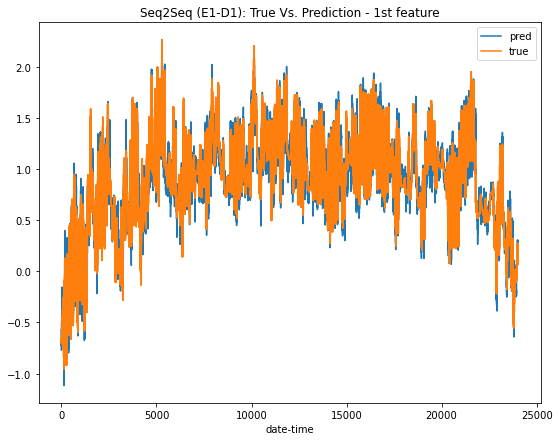

In [92]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e1_d1[:, :, 0].flatten(), label = 'pred')
plt.plot(y_test[:, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

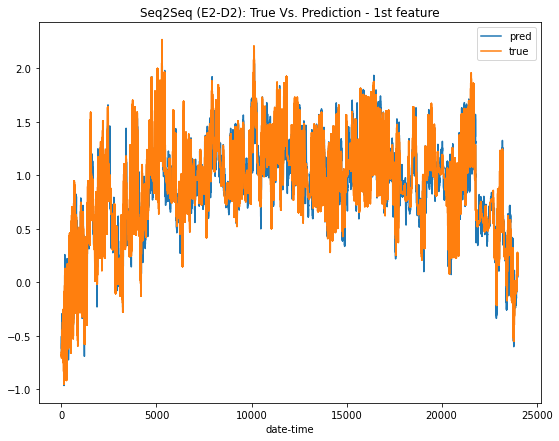

In [93]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e2_d2[:, :, 0].flatten(), label = 'pred')
plt.plot(y_test[:, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E2-D2): True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

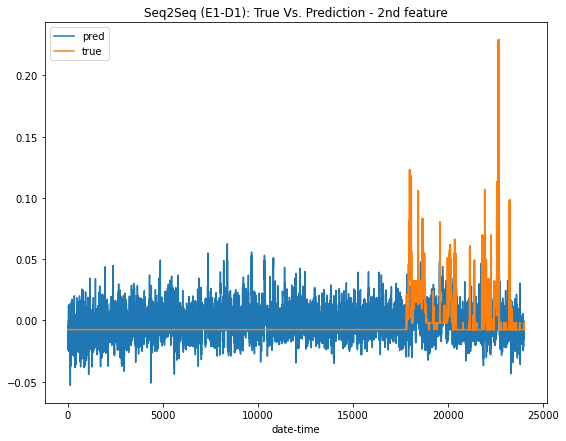

In [94]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e1_d1[:, :, 1].flatten(), label = 'pred')
plt.plot(y_test[:, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

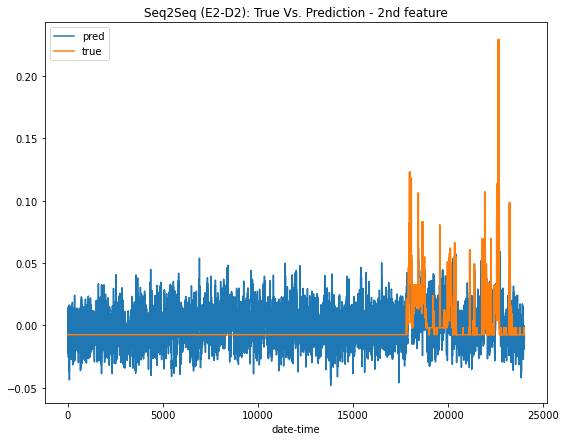

In [95]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e2_d2[:, :, 1].flatten(), label = 'pred')
plt.plot(y_test[:, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E2-D2): True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

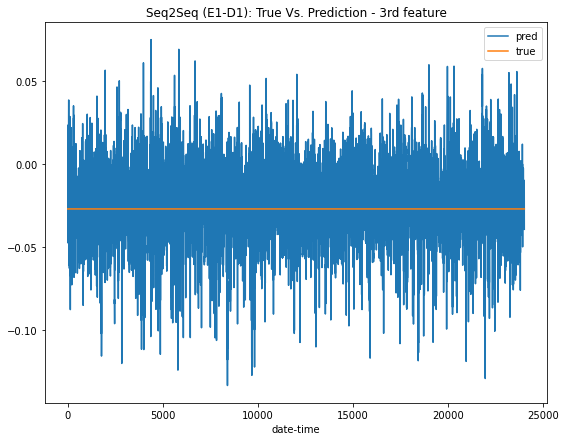

In [96]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e1_d1[:, :, 2].flatten(), label = 'pred')
plt.plot(y_test[:, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

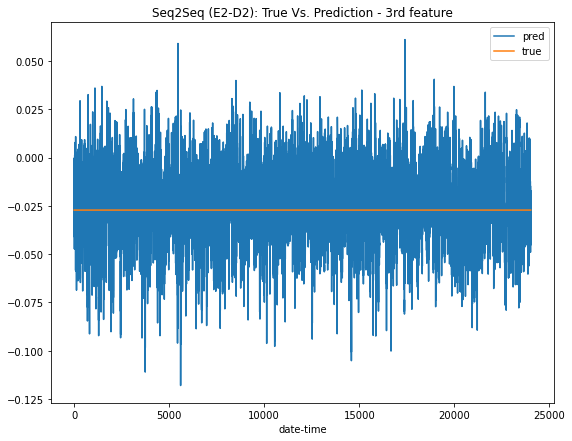

In [97]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e2_d2[:, :, 2].flatten(), label = 'pred')
plt.plot(y_test[:, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E2-D2): True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

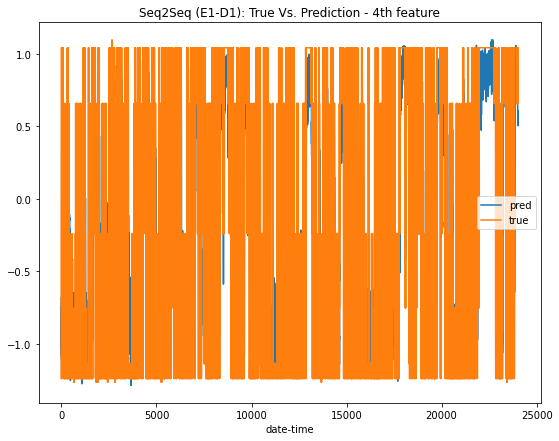

In [98]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e1_d1[:, :, 3].flatten(), label = 'pred')
plt.plot(y_test[:, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

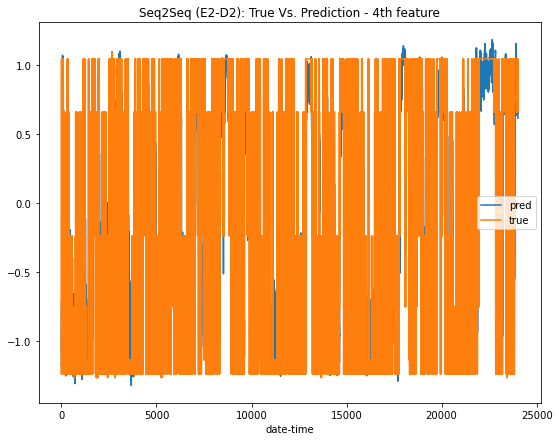

In [99]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e2_d2[:, :, 3].flatten(), label = 'pred')
plt.plot(y_test[:, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E2-D2): True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

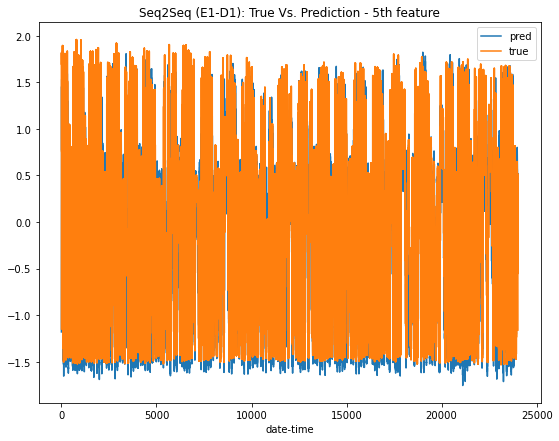

In [100]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e1_d1[:, :, 4].flatten(), label = 'pred')
plt.plot(y_test[:, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

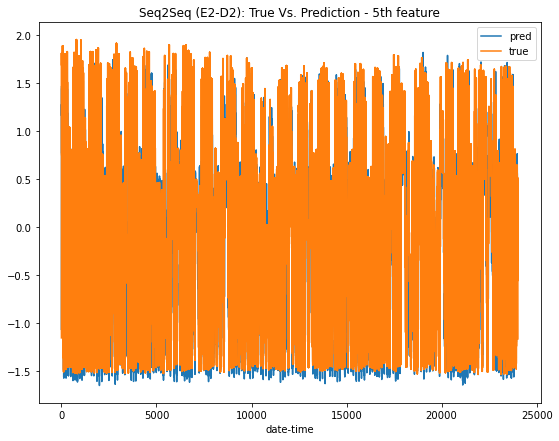

In [101]:
plt.figure(figsize = (9, 7))
plt.plot(y_pred_e2_d2[:, :, 4].flatten(), label = 'pred')
plt.plot(y_test[:, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E2-D2): True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()